# ID 58, Blackjack with Deep Q-Learning:
Morgan Crouch


Resources:

https://github.com/Pradhyo/blackjack/blob/master/blackjack.ipynb

https://github.com/nevenp/dqn_flappy_bird/blob/master/dqn.py

https://github.com/blue0107/DQN-blackjack-pokerbot/blob/master/simple%20DQN%20with%20openAI%20gym

https://github.com/nalkpas/CS230-2018-Project/blob/master/blackjack_DQN.py

Connect Local:

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' \
  --port=9090 --no-browser

In [0]:
import time 
import random
import sys 
import os

import gym
from gym.envs.toy_text import blackjack

from IPython.display import clear_output
import pdb

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

# Override function so dont have to convert bool to int 
# every time the result is put through network
def new_usable_ace(hand):
    return int(1 in hand and sum(hand) + 10 <= 21)
    
blackjack.usable_ace = new_usable_ace

GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

## Setting up the Blackjack Env

**From the BlackJackEnv Doc string:**

```
    Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.

    Face cards (Jack, Queen, King) have point value 10.a
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.

    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.

    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).

    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
```



In [3]:
env = gym.make('Blackjack-v0')
env.reset()

(18, 10, 0)

In [4]:
print(f'Action space: {env.action_space}. \n\n=> (1 = Hit, 0 = Bust)\n') 
print('-----------------------------------------------\n')
print(f'Observation space: {env.observation_space} \n\n=> (Player hand sum, Dealer card, Usable ace)')


Action space: Discrete(2). 

=> (1 = Hit, 0 = Bust)

-----------------------------------------------

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2)) 

=> (Player hand sum, Dealer card, Usable ace)


In [5]:
print("Observation Space:")
print('=> ', env.step(0))
# Observation, Reward, Done, Diagnostic Info (empty)

Observation Space:
=>  ((18, 10, 0), 1.0, True, {})


## Random Actions Result

In [6]:
#@title Default title text
# From basic Q learning example:https://github.com/Pradhyo/blackjack/blob/master/blackjack.ipynb

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

average_payouts = []
start_time = time.time()
for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action 
        obs, payout, is_done, _ = env.step(action)
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

  
print ("Average reward after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))
print(f"Average per round is {sum(average_payouts) / num_samples / num_rounds:0.3f}")

Average reward after 1000 rounds is -393.0
Average per round is -0.393


## Plot Helper Functions
First two from MatPlotLib documentation example

In [0]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


# Displays the action taken for each possible state
def show_action_tables(hard_preds, soft_preds, title_hard='', title_soft='', fig_title=''):
    dealer_states = list(range(2, 12))
    player_hard_states = list(range(4, 22))
    player_soft_states = ['A, 2', 'A, 3', 'A, 4', 'A, 5', 'A, 6', 'A, 7', 'A, 8', 'A, 9', 'A, 10']

    hard_hand_actions = hard_preds.int().numpy().reshape((18, 10))
    soft_hand_actions = soft_preds.int().numpy().reshape((8, 10))

    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    # Hard table
    ax[0].title.set_text(title_hard)
    im = heatmap(hard_hand_actions, player_hard_states, dealer_states, ax=ax[0],
                       cmap="Wistia")
    annotate_heatmap(im, valfmt="{x}")

    # Soft table
    im = heatmap(soft_hand_actions, player_soft_states, dealer_states, ax=ax[1],
                 cmap="Wistia")
    annotate_heatmap(im, valfmt="{x}")
    ax[1].title.set_text(title_soft)

    if fig_title:
        fig.suptitle(fig_title)

    fig.tight_layout()
    plt.show()

## Create the ideal solution

In [0]:
def create_ideal_solution():
    """Create all potential blackjack states and the ideal action for each state"""
    # Note: Dealer always stands on 17. If player has Ace, it will show the highest possible hand value
    # X hard totals
    player_states = 18
    dealer_states = 10

    # All hard hand inputs
    # Player 4 - 21, Dealer 2 - 11
    x_hard_hand = np.zeros((player_states * dealer_states, 3))
    for i in range(player_states * dealer_states):
        dealer_card = np.floor(i / player_states)
        player_card = i % player_states
        x_hard_hand[i] = (player_card + 4, dealer_card + 2, 0)

    # Create ideal hard hand actions
    y_hard_hand = np.ones((player_states, dealer_states))
    for player_total in range(9, player_states + 4):
        for dealer_total in range(2, dealer_states + 2):
            player_idx = player_total - 4
            dealer_idx = dealer_total - 2

            # Times to stand
            if player_total >= 17:
                y_hard_hand[player_idx][dealer_idx] = 0

            if 13 <= player_total <= 16:
                if dealer_total <= 6:
                    y_hard_hand[player_idx][dealer_idx] = 0

            if player_total == 12 and 4 <= dealer_total <= 6:
                y_hard_hand[player_idx][dealer_idx] = 0

    # X soft totals
    player_states = 8
    dealer_states = 10

    # All soft hand inputs
    # Player 13 - 20, Dealer 2 - 11
    x_soft_hand = np.zeros((player_states * dealer_states, 3))
    for i in range(player_states * dealer_states):
        dealer_card = np.floor(i / player_states)
        player_card = i % player_states
        x_soft_hand[i] = (player_card + 13, dealer_card + 2, 1)

    # Create ideal soft hand actions
    y_soft_hand = np.ones((player_states, dealer_states))
    for player_total in range(18, player_states + 13):
        for dealer_total in range(2, dealer_states + 2):
            player_idx = player_total - 13
            dealer_idx = dealer_total - 2

            # Times to stand
            if player_total >= 19:
                y_soft_hand[player_idx][dealer_idx] = 0

            if player_total == 18:
                if dealer_total <= 8:
                    y_soft_hand[player_idx][dealer_idx] = 0

    x_soft_hand = torch.from_numpy(x_soft_hand).float() 
    x_hard_hand = torch.from_numpy(x_hard_hand).float()
    y_soft_hand = torch.from_numpy(y_soft_hand.reshape((-1, 1))).float()
    y_hard_hand = torch.from_numpy(y_hard_hand.reshape((-1, 1))).float()

    return x_soft_hand, x_hard_hand, y_soft_hand, y_hard_hand 

In [0]:
IDEAL_SOLUTION = create_ideal_solution()

## Creating the Model

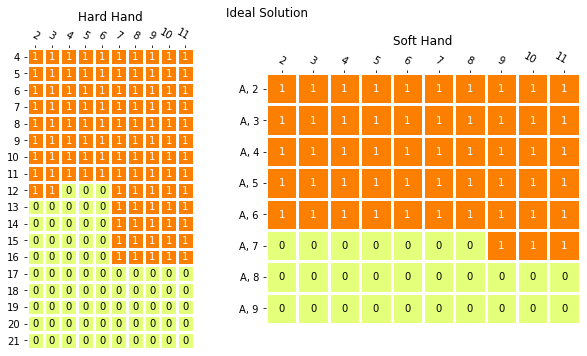

In [10]:
class DQNetwork(nn.Module):
    def __init__(self, ideal_sol, number_of_states=3, number_of_actions=2, weight_norm=False):
        super(DQNetwork, self).__init__()
        self.current_episode = 0

        self.fc1 = nn.Linear(number_of_states, 96)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(96, 48)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(48, 24)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(24, number_of_actions)

        if weight_norm:
            self.fc1 = nn.utils.weight_norm(self.fc1)
            self.fc2 = nn.utils.weight_norm(self.fc2)
            self.fc3 = nn.utils.weight_norm(self.fc3)
          
        self.x_soft_hand = ideal_sol[0]
        self.x_hard_hand = ideal_sol[1]
        self.y_soft_hand = ideal_sol[2]
        self.y_hard_hand = ideal_sol[3]


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)

        return out   

# Show the ideal action for all states
show_action_tables(DQNetwork(IDEAL_SOLUTION).y_hard_hand, 
                   DQNetwork(IDEAL_SOLUTION).y_soft_hand,
                   title_hard='Hard Hand', 
                   title_soft='Soft Hand', 
                   fig_title="Ideal Solution")

This projects aim is for the model to create a q table that matches the 'Soft Total' and 'Hard Total' tables below
[link text](https://)

![Basic](https://www.blackjackapprenticeship.com/wp-content/uploads/2018/08/BJA_Basic_Strategy.jpg)

Source: https://www.blackjackapprenticeship.com/blackjack-strategy-charts/

### Basics of Q learning

---



The sequence of actions that generate the highest reward for a state and action:


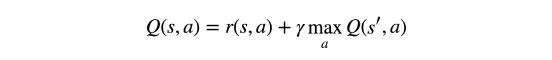

As the next state s' depends on the future state s'', the equation can be written as belowm, with a discount coefficient of gamma so that states further into the future contribute a diminishing reward.

alt text

We start at an arbitrary estimation of all Q values and as we train, it should converge as newer info overrides older info at a rate determined by alpha

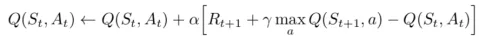

For deep q learning, the neural network approximates the Q-value function. The aim is to give the network a state and to recieve the Q value for all the available actions. Then select the Action that is predicted to give the greatest future reward.

Images from:
https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/

## Implement experience memory

Memory of previous actions to be fed into the network as "experience replay"

Class based on: 
https://github.com/nalkpas/CS230-2018-Project/blob/master/blackjack_DQN.py


In [0]:
class Memory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, cur_state, action, next_state, reward, done):
        # """Add the state, action and consequential state to memeory as Tensors"""

        cur_state_t = torch.Tensor(cur_state)
        action_t = torch.Tensor([action])
        next_state_t = torch.Tensor(next_state)
        rewart_t = torch.Tensor([reward])
        done_t = torch.Tensor([done])

        state_trans = [cur_state_t, action_t, rewart_t, next_state_t, done_t]

        if len(self.memory) < self.capacity:
            self.memory.append(state_trans)
        else:
            self.memory[self.position] = state_trans
            self.position = (self.position + 1) % self.capacity

    def sample(self, batchsize=10):
        """Return tensors needed to train model"""
        minibatch = random.sample(self.memory, batchsize)

        state_batch = torch.stack(tuple(sample[0] for sample in minibatch))
        action_batch = torch.stack(tuple(sample[1] for sample in minibatch))
        reward_batch = torch.stack(tuple(sample[2] for sample in minibatch))
        state_1_batch = torch.stack(tuple(sample[3] for sample in minibatch))
        done_batch = torch.stack(tuple(sample[4] for sample in minibatch))

        return state_batch, action_batch, reward_batch, state_1_batch, done_batch

    def __len__(self):
        return len(self.memory)

## Training Functions
Training functions used the following github projects as a starting point

https://github.com/blue0107/DQN-blackjack-pokerbot/blob/master/simple%20DQN%20with%20openAI%20gym
https://github.com/nevenp/dqn_flappy_bird/blob/master/dqn.py

In [0]:
def train_net(model, optimizer, memory, loss_func, n_steps, n_episodes, save_path, loggers, exp_epsilon_decay=False):
    # Log the training and validation improvements
    training_loss_logger, hard_accuracy_logger, soft_accuracy_logger = loggers

    epsilon_decrements = []
    
    if exp_epsilon_decay:
        epsilon_decrements = [EPSILON_INITIAL]
        found_eps_min = False
        for i in range(TOTAL_EPISODES):
            if epsilon_decrements[i] > EPSILON_FINAL:
                epsilon_decrements.append(epsilon_decrements[i] * EPSILON_DECAY)
            elif not found_eps_min:
                epsilon_decrements.append(epsilon_decrements[i])
                print(f'Minimum Epsilon reached in {i} episodes')
                found_eps_min = True
            else:
                epsilon_decrements.append(epsilon_decrements[i])
   
    else:
        epsilon_decrements = np.linspace(EPSILON_INITIAL, EPSILON_FINAL, n_episodes+1)

    

    start_time = time.time()
    for episode_idx in range(model.current_episode, model.current_episode + n_episodes + 1):
        # Decrement epsilon
        epsilon = epsilon_decrements[episode_idx - model.current_episode]  # TODO: Update so exponential decay

        # Call the training function
        training_loss_logger = train(model, optimizer, memory, loss_func,
                                     epsilon, n_steps, training_loss_logger)

        # Log model accuracy for episode
        hard_accuracy, soft_accuracy = evaluate(model)

        hard_accuracy_logger.append(hard_accuracy)
        soft_accuracy_logger.append(soft_accuracy)
        loggers = training_loss_logger, hard_accuracy_logger, soft_accuracy_logger

        # Save a checkpoint every 2000 episodes
        if episode_idx % 2000 == 0:
            if episode_idx != 0:
                clear_output()
            evaluate(model, display_result=True, episode_idx=episode_idx)
            torch.save({
                'episode_idx': episode_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loggers': loggers,
                'hyperparams_dict': hyperparams_dict,
                'episode_idx': episode_idx
            }, save_path)
            print('Model Saved')

        if episode_idx % 200 == 0:
            print(f'| Episode: {episode_idx:02} | Train Loss: {training_loss_logger[episode_idx-1]:0.2f} '
                  f'| Hard Acc: {hard_accuracy:0.2f} | Soft Acc: {soft_accuracy:0.2f} |')

    end_time = time.time()
    print("Training time %.2f seconds" % (end_time - start_time))

    return loggers

In [0]:
def train(model, optimizer, memory, loss_func, epsilon, n_steps, loss_logger):
    """Perform a single training episode"""
    cur_state = env.reset()
    with torch.no_grad():
        # Have the model play blackjack for n_steps and save result to memory, uses epsilon greedy to explore
        for step_i in range(n_steps):
            cur_state_t = torch.Tensor(cur_state).to(device)
            action = get_action(model, cur_state_t, epsilon)
            next_state, reward, is_done, _ = env.step(action)
            memory.push(cur_state, action, next_state, reward, is_done)
            if is_done:
                cur_state = env.reset()  # Environment deals new cards to player and dealer
            else:
                cur_state = next_state

    # Every n_steps, update the model based on loggers
    if len(memory) > MINIBATCH_SIZE:
        update_network(model, optimizer, memory, loss_func, loss_logger)

    return loss_logger

In [0]:
def evaluate(model, display_result=False, episode_idx=0):
    model.eval()
    with torch.no_grad():
        x_hard_hand = model.x_hard_hand.to(device)  
        x_soft_hand = model.x_soft_hand.to(device)  


        y_pred_hard = model(x_hard_hand)
        y_pred_hard = torch.max(y_pred_hard, 1)[1].float()
        y_pred_hard = y_pred_hard.reshape((10, 18)).t().reshape((-1, 180)).squeeze()

        y_pred_soft = model(x_soft_hand)
        y_pred_soft = torch.max(y_pred_soft, 1)[1].float()  
        y_pred_soft = y_pred_soft.reshape((10, 8)).t().reshape((-1, 80)).squeeze()

        y_hard = model.y_hard_hand.squeeze()
        y_soft = model.y_soft_hand.squeeze()

        correct_action_hard = torch.eq(y_hard, y_pred_hard)
        correct_action_soft = torch.eq(y_soft, y_pred_soft)

        correct_action_hard = correct_action_hard.reshape((18, 10))
        correct_action_soft = correct_action_soft.reshape((8, 10))

        fig_title = f'Episodes: {episode_idx}' if episode_idx > 0 else None

        if display_result:
            show_action_tables(y_pred_hard, y_pred_soft,
                               "Hard Hand Actions by Model", "Soft Hand Actions by Model", fig_title=fig_title)

        if correct_action_hard.sum().item() != 0:
            hard_hand_accuracy =  correct_action_hard.sum().item() / correct_action_hard.numel() * 100
        else:
            hard_hand_accuracy = 0
        if correct_action_soft.sum().item() != 0:
            soft_hand_accuracy = correct_action_soft.sum().item() / correct_action_soft.numel() * 100
        else:
            soft_hand_accuracy = 0

        return hard_hand_accuracy, soft_hand_accuracy

In [0]:
def get_action(model, cur_state, epsilon):
    """Output an action from either the recomendation from the NN
    or a random choice, depending on epsilon."""
    if np.random.rand() < epsilon:
        return np.random.randint(0, NUMBER_OF_ACTIONS)
    else:
        predicted_action = model(cur_state)
        values, index = predicted_action.max(0)

        return index.item()


def update_network(model, optimizer, memory, loss_func, loss_logger):
    """Use the experience replay memory to train the network.

    Loss function based on what the current model predicts as the Q values, vs the Q values that were found
    from the models memory."""
    model.train()
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = memory.sample(MINIBATCH_SIZE)
    state_batch = state_batch.to(device)
    action_batch = action_batch.to(device)
    reward_batch = reward_batch.to(device)
    next_state_batch = next_state_batch.to(device)
    done_batch = done_batch.to(device)


    current_state_qs = model(state_batch)  # Shape = [batch_size, action_size]
    next_state_qs = model(next_state_batch)
    target_qs_list = []

    for i in range(MINIBATCH_SIZE):
        # If the Action didn't cause it to finish, the max q is given from the next q values * gamma discount
        if not done_batch[i]:
            max_future_q = torch.max(next_state_qs[i])
            new_q = reward_batch[i] + GAMMA * max_future_q
        # If final state reached, the max q of the action taken is the reward value received
        else:
            new_q = reward_batch[i]

        action_taken = int(action_batch[i].item())
        current_qs = current_state_qs[i].clone()  # Need to clone it, or overrides original tensor
        current_qs[action_taken] = new_q
        target_qs_list.append(current_qs)

    target_q_values = torch.stack(target_qs_list)

    optimizer.zero_grad()

    # Calculate Loss
    loss = loss_func(current_state_qs, target_q_values)
    loss_logger.append(loss.item())
    loss.backward()

    # Update Model
    optimizer.step()
    model.eval()

## Utility Functions

### Function to load Checkpointing

In [0]:
def load_model(model, save_dir, save_path, load_checkpoint=False, load_hyperparams=False):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
  #Load Checkpoint
    if load_checkpoint:
        #Check if checkpoint exists
        if os.path.isfile(save_path):
            #load Checkpoint
            check_point = torch.load(save_path)
            model.load_state_dict(check_point['model_state_dict'])
            model.optimizer.load_state_dict(check_point['optimizer_state_dict'])
            model.current_episode = check_point['episode_idx']
            model.loggers = check_point['loggers']
            print(f'Current Hard Accuracy: {model.loggers[1][model.current_episode]:0.2f}, '
                  f'Current Soft Accuracy: {model.loggers[2][model.current_episode]:0.2f}')
            print("Checkpoint loaded, starting from episode:", model.current_episode)
            return True
        
        else:
            print("Checkpoint Does not exist")
            return False

    elif load_hyperparams:
        check_point = torch.load(save_path)
        hyperparams_dict = check_point['hyperparams_dict']

        global NUMBER_OF_ACTIONS, NUMBER_OF_STATES, EPSILON_FINAL, EPSILON_FINAL, EPSILON_DECAY, GAMMA, \
               REPLAY_MEMORY_SIZE, MINIBATCH_SIZE, STEPS_PER_EPISODE, TOTAL_EPISODES, LEARNING_RATE
        NUMBER_OF_ACTIONS = hyperparams_dict['NUMBER_OF_ACTIONS']
        NUMBER_OF_STATES = hyperparams_dict['NUMBER_OF_STATES']
        EPSILON_FINAL = ['EPSILON_FINAL']
        EPSILON_DECAY = hyperparams_dict['EPSILON_DECAY']
        GAMMA = hyperparams_dict['GAMMA']
        REPLAY_MEMORY_SIZE = hyperparams_dict['REPLAY_MEMORY_SIZE']
        MINIBATCH_SIZE = hyperparams_dict['MINIBATCH_SIZE']
        STEPS_PER_EPISODE = hyperparams_dict['STEPS_PER_EPISODE']
        TOTAL_EPISODES = hyperparams_dict['TOTAL_EPISODES']
        LEARNING_RATE = hyperparams_dict['LEARNING_RATE']

        print('Hyperparams loaded from the checkpoint')
        return False

    else:
        print('No model loaded')
        return False

### Function to get model's resutls

In [0]:
def obtain_model_result(model, save_path):
    model.optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    memory = Memory(REPLAY_MEMORY_SIZE)
    loss_func = nn.MSELoss()

    # Reset loggers to empty
    training_loss_logger = [0]
    hard_accuracy_logger = []
    soft_accuracy_logger = []
    model.loggers = training_loss_logger, hard_accuracy_logger, soft_accuracy_logger

    # Load a previous model
    load_checkpoint = True
    load_only_hyperparams = False
    checkpoint_loaded = load_model(model, save_dir, save_path, load_checkpoint, load_only_hyperparams)

    if not checkpoint_loaded:
        loggers = train_net(model, model.optimizer, memory, loss_func, STEPS_PER_EPISODE, TOTAL_EPISODES, save_path, model.loggers)
    
    return model.loggers

### Function for plotting results

In [0]:
def plot_results(results):
    loss_logger = results[0]
    hard_accuracy_logger = results[1]
    soft_accuracy_logger = results[2]


    plt.figure(figsize=(14, 7))
    # ---- Useless logging loss ----
    # plt.subplot(2, 1, 1)
    # x = np.linspace(0, TOTAL_EPISODES, len(loss_logger))
    # plt.plot(x, loss_logger, c="y")
    # plt.title("Loss per Episode")
    # plt.legend(["Training Loss"])

    #plt.subplot(2, 1, 2)
    x = np.linspace(0, TOTAL_EPISODES, len(hard_accuracy_logger))
    plt.plot(x, hard_accuracy_logger, c="r")
    plt.plot(x, soft_accuracy_logger, c="b")

    plt.legend(["Hard Hand Accuracy", "Soft Hand Accuracy"])
    plt.title("Accuracy per Episode")

    plt.show()


### Connect with Google Drive


In [0]:
if IN_COLAB:
    drive.mount('/content/drive')
    ROOT = "/content/drive/My Drive/ECE4179-2019/Project/"
    sys.path.append(ROOT)
else:
    ROOT = r"C:\Users\morga\Documents\University_Work\ECE4179/"
    sys.path.append(ROOT)

save_dir = ROOT + 'Models'


# Train the baseline model

---



### Hyperparametes

In [0]:
NUMBER_OF_ACTIONS = 2
NUMBER_OF_STATES = 3

EPSILON_INITIAL = 1
EPSILON_FINAL = 0.01
EPSILON_DECAY = 0.9  # TODO: Implement
GAMMA = 0.999  # discount factor for importance of future rewards

REPLAY_MEMORY_SIZE = 5000
MINIBATCH_SIZE = 256

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 50_000
LEARNING_RATE = 1e-5

# Input for saving the model
hyperparams_dict = {
    'NUMBER_OF_ACTIONS': NUMBER_OF_ACTIONS,
    'NUMBER_OF_STATES': NUMBER_OF_STATES,
    'EPSILON_FINAL': EPSILON_FINAL,
    'EPSILON_DECAY': EPSILON_DECAY,
    'GAMMA': GAMMA,
    'REPLAY_MEMORY_SIZE': REPLAY_MEMORY_SIZE,
    'MINIBATCH_SIZE': MINIBATCH_SIZE,
    'STEPS_PER_EPISODE': STEPS_PER_EPISODE,
    'TOTAL_EPISODES': TOTAL_EPISODES,
    'LEARNING_RATE': LEARNING_RATE,
}


In [21]:
# Create the model
model = DQNetwork(IDEAL_SOLUTION, weight_norm=False).to(device) 

# Creat model file name
version = 1.2
model_name = f'Full_Model_Run_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

# Will train the model if it does not exist
loggers = obtain_model_result(model, save_path)

Current Hard Accuracy: 91.11, Current Soft Accuracy: 82.50
Checkpoint loaded, starting from episode: 50000


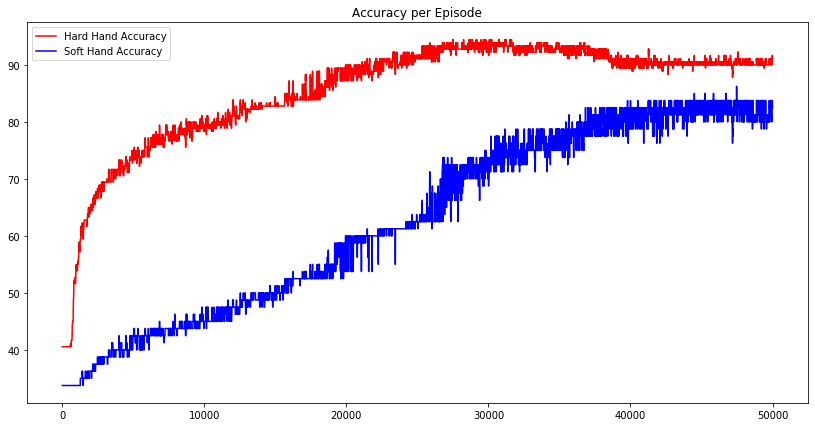

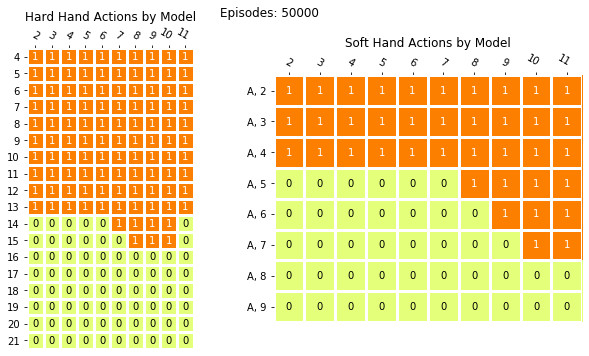

Hard Acc Final: 91.11, Soft Acc Final: 82.50


In [22]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

### Compare with random guessing

In [23]:
# For comparison to the random model at the start

num_rounds = 10000  # reward calculated over num_rounds
num_samples = 10  # num_rounds simulated over num_samples
average_reward = []

model.eval()
actions_taken = []
with torch.no_grad():
    win = 0 
    lose = 0
    draw = 0
    for sample in range(num_samples):
        round = 1    
        total_reward = 0  # to store total reward over 'num_rounds'
        cur_state = env.reset()
        while round <= num_rounds:
            cur_state_t = torch.Tensor(cur_state).to(device)
            action = get_action(model, cur_state_t, 0)
            if round % 10 == 0:
                actions_taken.append(action)
            cur_state, reward, is_done, _ = env.step(action)

            total_reward += reward
        
            if is_done:
                if reward == 1:
                    win += 1
                elif reward == -1: 
                    lose += 1 
                elif reward == 0:
                    draw += 1 
                cur_state = env.reset()  # Environment deals new cards to player and dealer
                round += 1
        average_reward.append(total_reward)

print(f'Wins: {win/(win+lose+draw)*100:0.2f}%, Lose: {lose/(win+lose+draw)*100:0.2f}%, Draw: {draw/(win+lose+draw)*100:0.2f}%')
print(f"Average reward for {num_rounds} rounds is {sum(average_reward) / num_samples}\n" \
      f"Average per round is {sum(average_reward) / num_samples / num_rounds:0.3f}\n"
      f"Average per round for random is -0.4 ")

Wins: 42.44%, Lose: 48.47%, Draw: 9.09%
Average reward for 10000 rounds is -602.6
Average per round is -0.060
Average per round for random is -0.4 


# Tuning of the Network

---



## Weight Normalization for Linear Layers

In [0]:
class DQNetwork(nn.Module):
    def __init__(self, ideal_sol, number_of_states=3, number_of_actions=2, weight_norm=False):
        super(DQNetwork, self).__init__()
        self.current_episode = 0

        self.fc1 = nn.Linear(number_of_states, 96)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(96, 48)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(48, 24)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(24, number_of_actions)

        if weight_norm:
            self.fc1 = nn.utils.weight_norm(self.fc1)
            self.fc2 = nn.utils.weight_norm(self.fc2)
            self.fc3 = nn.utils.weight_norm(self.fc3)
            self.fc4 = nn.utils.weight_norm(self.fc4)
          
        self.x_soft_hand = ideal_sol[0]
        self.x_hard_hand = ideal_sol[1]
        self.y_soft_hand = ideal_sol[2]
        self.y_hard_hand = ideal_sol[3]


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)

        return out  

In [0]:
EPSILON_INITIAL = 1
EPSILON_FINAL = 0.01
GAMMA = 0.999  # discount factor for importance of future rewards

REPLAY_MEMORY_SIZE = 5000
MINIBATCH_SIZE = 256

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 30_000
LEARNING_RATE = 1e-5

# Input for saving the model
hyperparams_dict = {
    'NUMBER_OF_ACTIONS': NUMBER_OF_ACTIONS,
    'NUMBER_OF_STATES': NUMBER_OF_STATES,
    'EPSILON_FINAL': EPSILON_FINAL,
    'EPSILON_DECAY': EPSILON_DECAY,
    'GAMMA': GAMMA,
    'REPLAY_MEMORY_SIZE': REPLAY_MEMORY_SIZE,
    'MINIBATCH_SIZE': MINIBATCH_SIZE,
    'STEPS_PER_EPISODE': STEPS_PER_EPISODE,
    'TOTAL_EPISODES': TOTAL_EPISODES,
    'LEARNING_RATE': LEARNING_RATE,
}

### No weight normalization

In [26]:
model = DQNetwork(IDEAL_SOLUTION, weight_norm=False).to(device)

# Creat model file name
version = 1.5
model_name = f'Full_Model_No_Weight_Norm_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

loggers = obtain_model_result(model, save_path)


Current Hard Accuracy: 93.33, Current Soft Accuracy: 70.00
Checkpoint loaded, starting from episode: 30000


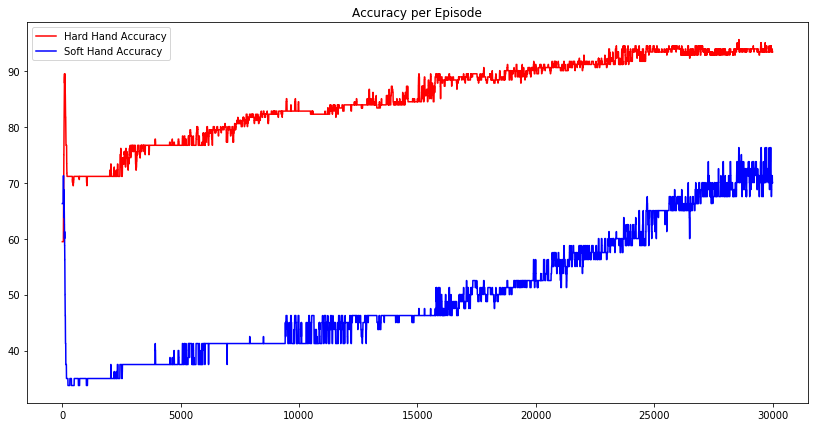

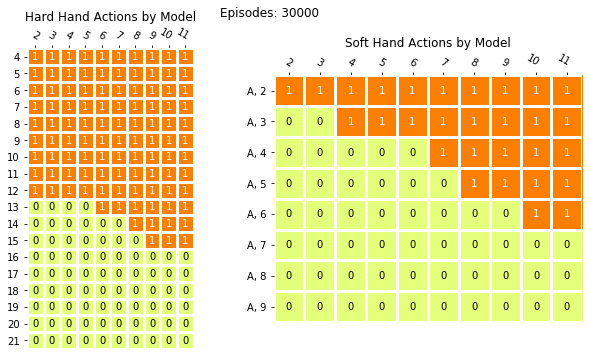

Hard Acc Final: 93.33, Soft Acc Final: 70.00


In [27]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

### Adding Weight Normalization to all Linear

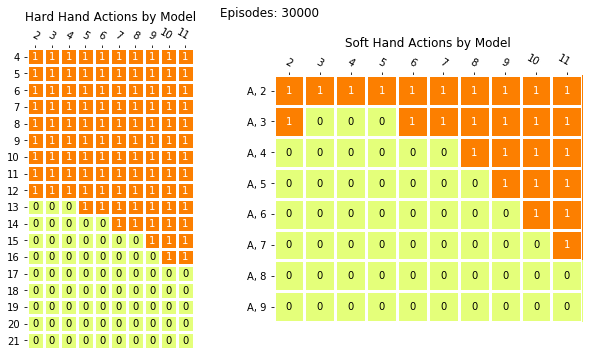

Model Saved
| Episode: 30000 | Train Loss: 0.26 | Hard Acc: 94.44 | Soft Acc: 67.50 |
Training time 1529.54 seconds


In [52]:
model = DQNetwork(IDEAL_SOLUTION, weight_norm=True).to(device)

# Creat model file name
version = 1.4
model_name = f'Full_Model_Weight_Norm_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

loggers = obtain_model_result(model, save_path)


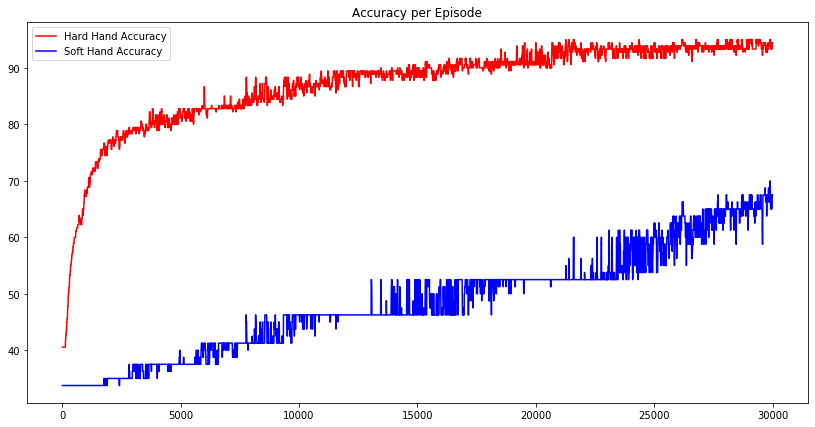

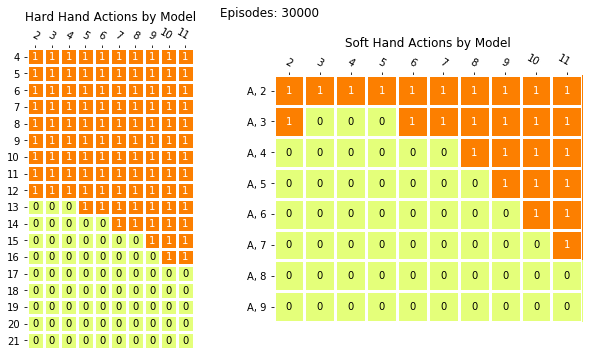

Hard Acc Final: 94.44, Soft Acc Final: 67.50


In [53]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

### Adding Weight Normalization to all but the last 

In [29]:
class DQNetwork(nn.Module):
    def __init__(self, ideal_sol, number_of_states=3, number_of_actions=2, weight_norm=False):
        super(DQNetwork, self).__init__()
        self.current_episode = 0

        self.fc1 = nn.Linear(number_of_states, 96)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(96, 48)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(48, 24)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(24, number_of_actions)

        if weight_norm:
            self.fc1 = nn.utils.weight_norm(self.fc1)
            self.fc2 = nn.utils.weight_norm(self.fc2)
            self.fc3 = nn.utils.weight_norm(self.fc3)
          
        self.x_soft_hand = ideal_sol[0]
        self.x_hard_hand = ideal_sol[1]
        self.y_soft_hand = ideal_sol[2]
        self.y_hard_hand = ideal_sol[3]


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)

        return out  

EPSILON_INITIAL = 1
EPSILON_FINAL = 0.01
GAMMA = 0.999  # discount factor for importance of future rewards

REPLAY_MEMORY_SIZE = 5000
MINIBATCH_SIZE = 256

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 30_000
LEARNING_RATE = 1e-5

# Input for saving the model
hyperparams_dict = {
    'NUMBER_OF_ACTIONS': NUMBER_OF_ACTIONS,
    'NUMBER_OF_STATES': NUMBER_OF_STATES,
    'EPSILON_FINAL': EPSILON_FINAL,
    'EPSILON_DECAY': EPSILON_DECAY,
    'GAMMA': GAMMA,
    'REPLAY_MEMORY_SIZE': REPLAY_MEMORY_SIZE,
    'MINIBATCH_SIZE': MINIBATCH_SIZE,
    'STEPS_PER_EPISODE': STEPS_PER_EPISODE,
    'TOTAL_EPISODES': TOTAL_EPISODES,
    'LEARNING_RATE': LEARNING_RATE,
}

model = DQNetwork(IDEAL_SOLUTION, weight_norm=True).to(device)

# Creat model file name
version = 1.0
model_name = f'Full_Model_Weight_Norm_Not_Last_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

loggers = obtain_model_result(model, save_path)



Current Hard Accuracy: 93.33, Current Soft Accuracy: 75.00
Checkpoint loaded, starting from episode: 30000


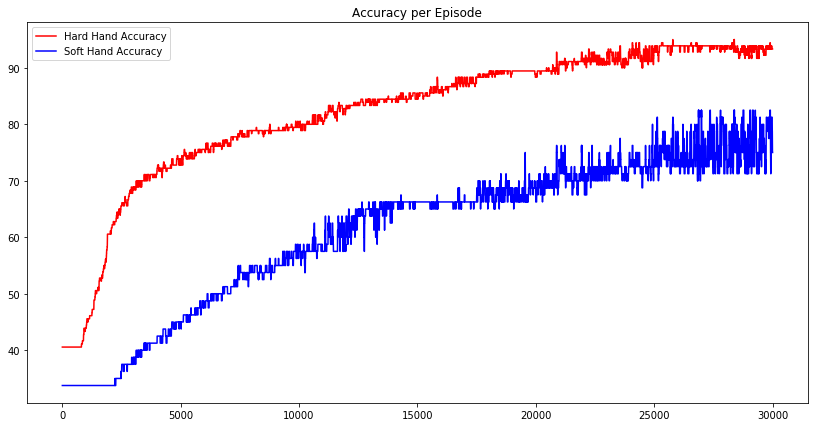

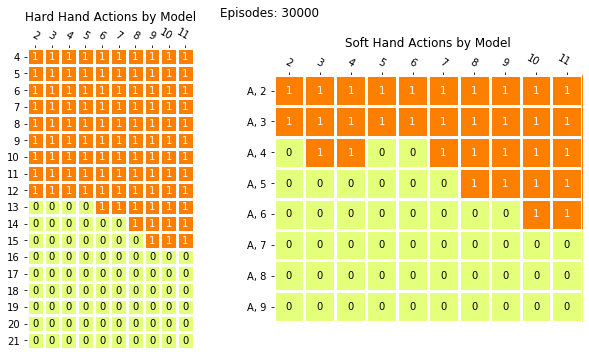

Hard Acc Final: 93.33, Soft Acc Final: 75.00


In [30]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

# Comparing Network Size

### Linear: (3 > 30), (30 > 30), (30 > 2) 

In [0]:
class DQNetwork(nn.Module):
    def __init__(self, ideal_sol, number_of_states=3, number_of_actions=2, weight_norm=False):
        super(DQNetwork, self).__init__()
        self.current_episode = 0

        self.fc1 = nn.Linear(number_of_states, 30)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(30, 30)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(30, number_of_actions)

        if weight_norm:
            self.fc1 = nn.utils.weight_norm(self.fc1)
            self.fc2 = nn.utils.weight_norm(self.fc2)
          
        self.x_soft_hand = ideal_sol[0]
        self.x_hard_hand = ideal_sol[1]
        self.y_soft_hand = ideal_sol[2]
        self.y_hard_hand = ideal_sol[3]


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)

        return out   

In [0]:
EPSILON_INITIAL = 1
EPSILON_FINAL = 0.01
GAMMA = 0.999  # discount factor for importance of future rewards

REPLAY_MEMORY_SIZE = 5000
MINIBATCH_SIZE = 256

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 20_000
LEARNING_RATE = 1e-5

# Input for saving the model
hyperparams_dict = {
    'NUMBER_OF_ACTIONS': NUMBER_OF_ACTIONS,
    'NUMBER_OF_STATES': NUMBER_OF_STATES,
    'EPSILON_FINAL': EPSILON_FINAL,
    'EPSILON_DECAY': EPSILON_DECAY,
    'GAMMA': GAMMA,
    'REPLAY_MEMORY_SIZE': REPLAY_MEMORY_SIZE,
    'MINIBATCH_SIZE': MINIBATCH_SIZE,
    'STEPS_PER_EPISODE': STEPS_PER_EPISODE,
    'TOTAL_EPISODES': TOTAL_EPISODES,
    'LEARNING_RATE': LEARNING_RATE,
}


In [33]:
# Reset Model state
model = DQNetwork(IDEAL_SOLUTION, weight_norm=True).to(device) 

# Creat model file name
version = 1.2
model_name = f'Three_Layer_30_Run_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

loggers = obtain_model_result(model, save_path)

Current Hard Accuracy: 88.89, Current Soft Accuracy: 46.25
Checkpoint loaded, starting from episode: 20000


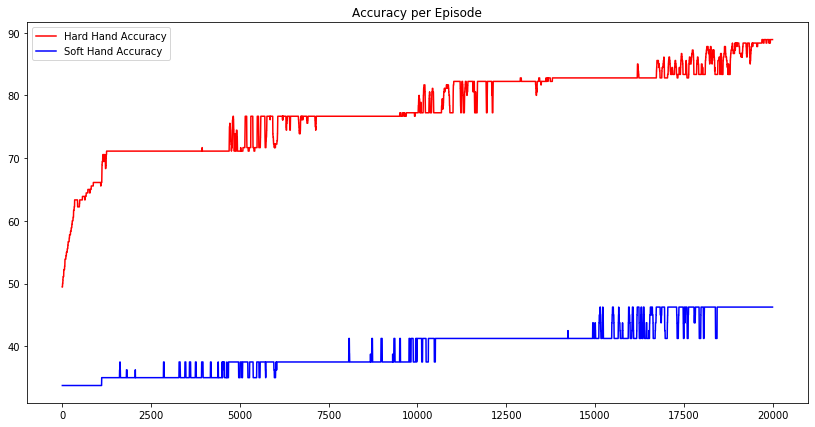

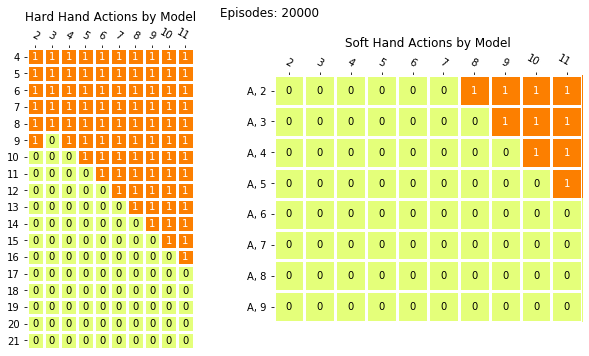

Hard Acc Final: 88.89, Soft Acc Final: 46.25


In [34]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

### Linear: (3 > 60), (60 > 20), (20 > 2) 

In [0]:
class DQNetwork(nn.Module):
    def __init__(self, ideal_sol, number_of_states=3, number_of_actions=2, weight_norm=False):
        super(DQNetwork, self).__init__()
        self.current_episode = 0

        self.fc1 = nn.Linear(number_of_states, 60)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(60, 20)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(20, number_of_actions)

        if weight_norm:
            self.fc1 = nn.utils.weight_norm(self.fc1)
            self.fc2 = nn.utils.weight_norm(self.fc2)
          
        self.x_soft_hand = ideal_sol[0]
        self.x_hard_hand = ideal_sol[1]
        self.y_soft_hand = ideal_sol[2]
        self.y_hard_hand = ideal_sol[3]

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)

        return out   

In [0]:
EPSILON_INITIAL = 1
EPSILON_FINAL = 0.01
GAMMA = 0.999  # discount factor for importance of future rewards

REPLAY_MEMORY_SIZE = 5000
MINIBATCH_SIZE = 256

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 20_000
LEARNING_RATE = 1e-5

# Input for saving the model
hyperparams_dict = {
    'NUMBER_OF_ACTIONS': NUMBER_OF_ACTIONS,
    'NUMBER_OF_STATES': NUMBER_OF_STATES,
    'EPSILON_FINAL': EPSILON_FINAL,
    'EPSILON_DECAY': EPSILON_DECAY,
    'GAMMA': GAMMA,
    'REPLAY_MEMORY_SIZE': REPLAY_MEMORY_SIZE,
    'MINIBATCH_SIZE': MINIBATCH_SIZE,
    'STEPS_PER_EPISODE': STEPS_PER_EPISODE,
    'TOTAL_EPISODES': TOTAL_EPISODES,
    'LEARNING_RATE': LEARNING_RATE,
}


In [37]:
model = DQNetwork(IDEAL_SOLUTION, weight_norm=True).to(device) 

# Creat model file name
version = 1.0
model_name = f'Three_Layer_60_20_Run_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

loggers = obtain_model_result(model, save_path)

Current Hard Accuracy: 90.00, Current Soft Accuracy: 53.75
Checkpoint loaded, starting from episode: 30000


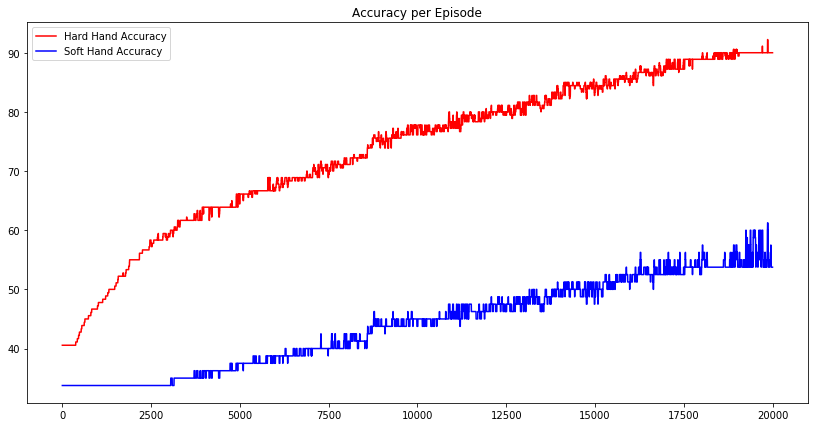

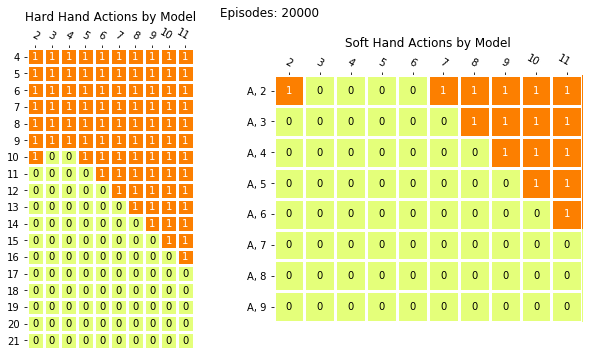

Hard Acc Final: 90.00, Soft Acc Final: 53.75


In [38]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

### Linear: (3 > 12), (12 > 2) 

In [0]:
class DQNetwork(nn.Module):
    def __init__(self, ideal_sol, number_of_states=3, number_of_actions=2, weight_norm=False):
        super(DQNetwork, self).__init__()
        self.current_episode = 0

        self.fc1 = nn.Linear(number_of_states, 12)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(12, number_of_actions)
        
        if weight_norm:
            self.fc1 = nn.utils.weight_norm(self.fc1)
          
        self.x_soft_hand = ideal_sol[0]
        self.x_hard_hand = ideal_sol[1]
        self.y_soft_hand = ideal_sol[2]
        self.y_hard_hand = ideal_sol[3]

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)

        return out   

In [0]:
EPSILON_INITIAL = 1
EPSILON_FINAL = 0.01
GAMMA = 0.999  # discount factor for importance of future rewards

REPLAY_MEMORY_SIZE = 5000
MINIBATCH_SIZE = 256

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 20_000
LEARNING_RATE = 1e-5

# Input for saving the model
hyperparams_dict = {
    'NUMBER_OF_ACTIONS': NUMBER_OF_ACTIONS,
    'NUMBER_OF_STATES': NUMBER_OF_STATES,
    'EPSILON_FINAL': EPSILON_FINAL,
    'EPSILON_DECAY': EPSILON_DECAY,
    'GAMMA': GAMMA,
    'REPLAY_MEMORY_SIZE': REPLAY_MEMORY_SIZE,
    'MINIBATCH_SIZE': MINIBATCH_SIZE,
    'STEPS_PER_EPISODE': STEPS_PER_EPISODE,
    'TOTAL_EPISODES': TOTAL_EPISODES,
    'LEARNING_RATE': LEARNING_RATE,
}


In [41]:
# Create the model
model = DQNetwork(IDEAL_SOLUTION, weight_norm=True).to(device) 

# Creat model file name
version = 1.2
model_name = f'Three_Layer_12_6_Run_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

loggers = obtain_model_result(model, save_path)

Current Hard Accuracy: 92.22, Current Soft Accuracy: 42.50
Checkpoint loaded, starting from episode: 20000


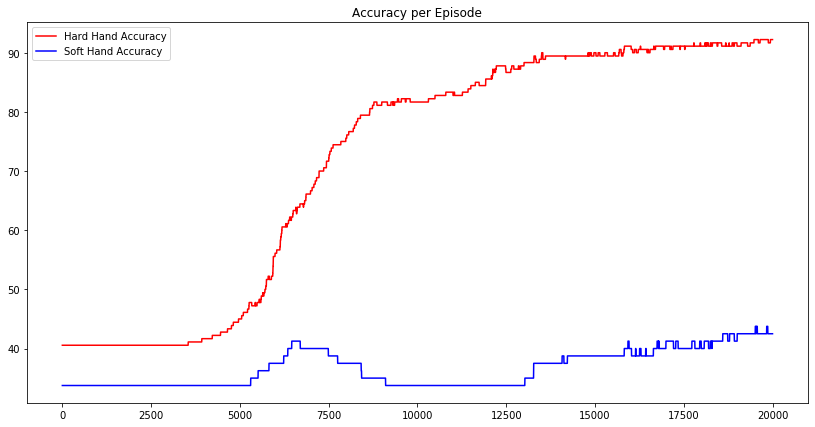

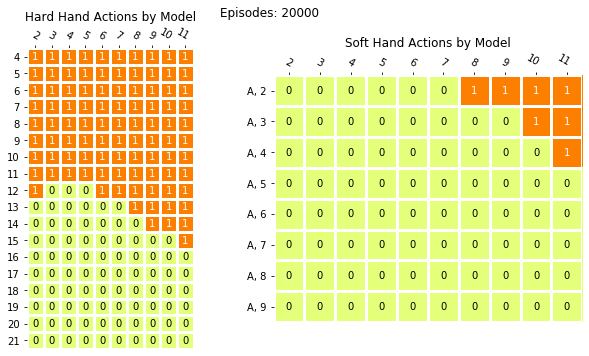

Hard Acc Final: 92.22, Soft Acc Final: 42.50


In [42]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

## Comparing Epsilon Decay and Epsilon Final Values

### Exponential Epsilon Decay

In [0]:
# Original
class DQNetwork(nn.Module):
    def __init__(self, ideal_sol, number_of_states=3, number_of_actions=2, weight_norm=False):
        super(DQNetwork, self).__init__()
        self.current_episode = 0

        self.fc1 = nn.Linear(number_of_states, 96)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(96, 48)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(48, 24)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(24, number_of_actions)

        if weight_norm:
            self.fc1 = nn.utils.weight_norm(self.fc1)
            self.fc2 = nn.utils.weight_norm(self.fc2)
            self.fc3 = nn.utils.weight_norm(self.fc3)
          
        self.x_soft_hand = ideal_sol[0]
        self.x_hard_hand = ideal_sol[1]
        self.y_soft_hand = ideal_sol[2]
        self.y_hard_hand = ideal_sol[3]


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)

        return out   

In [44]:
EPSILON_INITIAL = 1
EPSILON_DECAY = 0.999
EPSILON_FINAL = 0.01
GAMMA = 0.999  # discount factor for importance of future rewards

REPLAY_MEMORY_SIZE = 5000
MINIBATCH_SIZE = 256

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 20_000
LEARNING_RATE = 1e-5

# Input for saving the model
hyperparams_dict = {
    'NUMBER_OF_ACTIONS': NUMBER_OF_ACTIONS,
    'NUMBER_OF_STATES': NUMBER_OF_STATES,
    'EPSILON_FINAL': EPSILON_FINAL,
    'EPSILON_DECAY': EPSILON_DECAY,
    'GAMMA': GAMMA,
    'REPLAY_MEMORY_SIZE': REPLAY_MEMORY_SIZE,
    'MINIBATCH_SIZE': MINIBATCH_SIZE,
    'STEPS_PER_EPISODE': STEPS_PER_EPISODE,
    'TOTAL_EPISODES': TOTAL_EPISODES,
    'LEARNING_RATE': LEARNING_RATE,
}

def obtain_model_result(model, save_path):
    model.optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    memory = Memory(REPLAY_MEMORY_SIZE)
    loss_func = nn.MSELoss()

    # Reset loggers to empty
    training_loss_logger = [0]
    hard_accuracy_logger = []
    soft_accuracy_logger = []
    model.loggers = training_loss_logger, hard_accuracy_logger, soft_accuracy_logger

    # Load a previous model
    load_checkpoint = True
    load_only_hyperparams = False
    checkpoint_loaded = load_model(model, save_dir, save_path, load_checkpoint, load_only_hyperparams)

    if not checkpoint_loaded:
        loggers = train_net(model, model.optimizer, memory, loss_func, STEPS_PER_EPISODE, 
                            TOTAL_EPISODES, save_path, model.loggers,  exp_epsilon_decay=True)  # Exponential Epsilon Decay on
    
    return model.loggers

# Create the model
model = DQNetwork(IDEAL_SOLUTION, weight_norm=True).to(device) 

# Creat model file name
version = 1.6
model_name = f'Original_With_Exp_Eps_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

loggers = obtain_model_result(model, save_path)

Current Hard Accuracy: 93.33, Current Soft Accuracy: 50.00
Checkpoint loaded, starting from episode: 20000


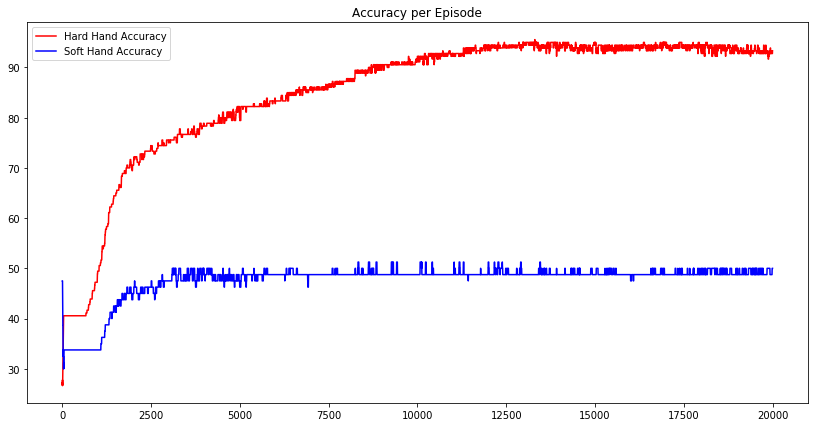

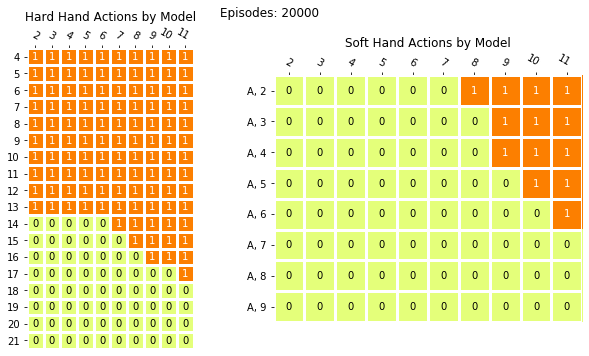

Hard Acc Final: 93.33, Soft Acc Final: 50.00


In [45]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

### Lower final epsilon

In [46]:
EPSILON_FINAL = 0.001
 
# Create the model
model = DQNetwork(IDEAL_SOLUTION, weight_norm=True).to(device) 

# Creat model file name
version = 1.0
model_name = f'Original_With_Exp_Eps_0.001_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")
# Min eps at 6905

loggers = obtain_model_result(model, save_path)

Current Hard Accuracy: 92.78, Current Soft Accuracy: 48.75
Checkpoint loaded, starting from episode: 20000


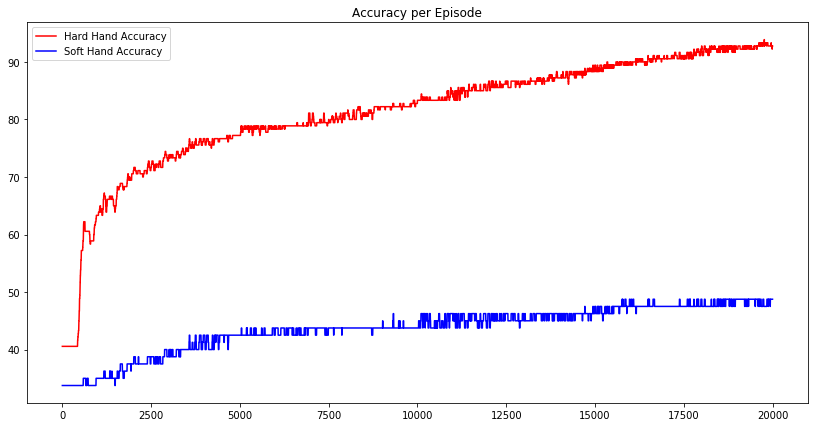

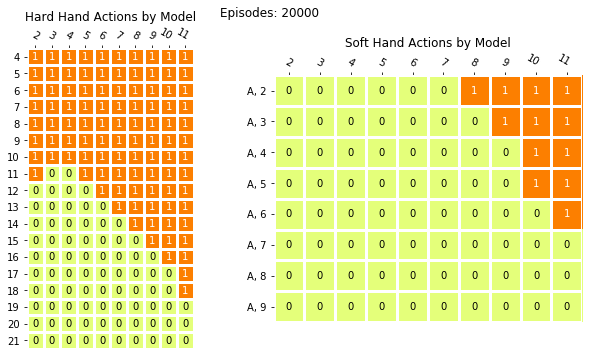

Hard Acc Final: 92.78, Soft Acc Final: 48.75


In [47]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

### Constant epsilon @ 0.05

In [48]:
EPSILON_INITIAL = 0.05
EPSILON_DECAY = 1
EPSILON_FINAL = 0.05
GAMMA = 0.999  # discount factor for importance of future rewards

REPLAY_MEMORY_SIZE = 5000
MINIBATCH_SIZE = 256

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 20_000
LEARNING_RATE = 1e-5

# Input for saving the model
hyperparams_dict = {
    'NUMBER_OF_ACTIONS': NUMBER_OF_ACTIONS,
    'NUMBER_OF_STATES': NUMBER_OF_STATES,
    'EPSILON_FINAL': EPSILON_FINAL,
    'EPSILON_DECAY': EPSILON_DECAY,
    'GAMMA': GAMMA,
    'REPLAY_MEMORY_SIZE': REPLAY_MEMORY_SIZE,
    'MINIBATCH_SIZE': MINIBATCH_SIZE,
    'STEPS_PER_EPISODE': STEPS_PER_EPISODE,
    'TOTAL_EPISODES': TOTAL_EPISODES,
    'LEARNING_RATE': LEARNING_RATE,
}

def obtain_model_result(model, save_path):
    model.optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    memory = Memory(REPLAY_MEMORY_SIZE)
    loss_func = nn.MSELoss()

    # Reset loggers to empty
    training_loss_logger = [0]
    hard_accuracy_logger = []
    soft_accuracy_logger = []
    model.loggers = training_loss_logger, hard_accuracy_logger, soft_accuracy_logger

    # Load a previous model
    load_checkpoint = True
    load_only_hyperparams = False
    checkpoint_loaded = load_model(model, save_dir, save_path, load_checkpoint, load_only_hyperparams)

    if not checkpoint_loaded:
        loggers = train_net(model, model.optimizer, memory, loss_func, STEPS_PER_EPISODE, 
                            TOTAL_EPISODES, save_path, model.loggers,  exp_epsilon_decay=True)  # Exponential Epsilon Decay on
    
    return model.loggers

# Create the model
model = DQNetwork(IDEAL_SOLUTION, weight_norm=True).to(device) 

# Creat model file name
version = 1.0
model_name = f'Original_With_Constant_Eps_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

loggers = obtain_model_result(model, save_path)

Current Hard Accuracy: 92.78, Current Soft Accuracy: 53.75
Checkpoint loaded, starting from episode: 20000


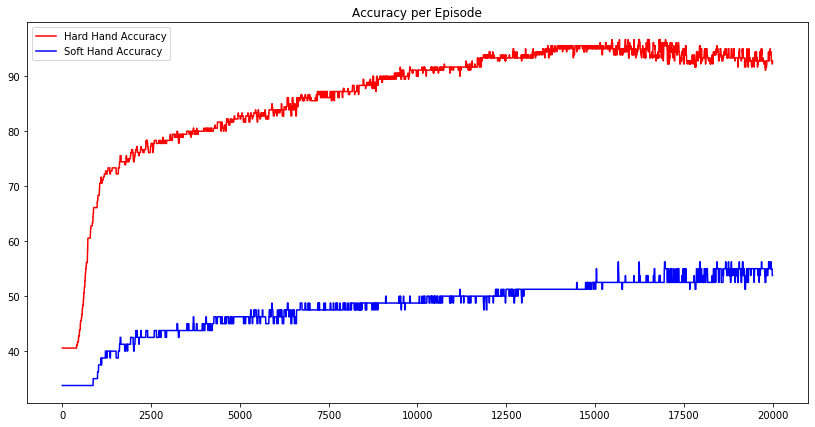

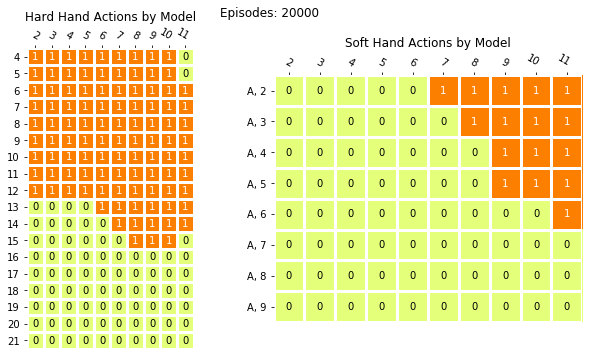

Hard Acc Final: 92.78, Soft Acc Final: 53.75


In [49]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')

## Minibatach size

In [50]:
class DQNetwork(nn.Module):
    def __init__(self, ideal_sol, number_of_states=3, number_of_actions=2, weight_norm=False):
        super(DQNetwork, self).__init__()
        self.current_episode = 0

        self.fc1 = nn.Linear(number_of_states, 96)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(96, 48)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(48, 24)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(24, number_of_actions)

        if weight_norm:
            self.fc1 = nn.utils.weight_norm(self.fc1)
            self.fc2 = nn.utils.weight_norm(self.fc2)
            self.fc3 = nn.utils.weight_norm(self.fc3)
          
        self.x_soft_hand = ideal_sol[0]
        self.x_hard_hand = ideal_sol[1]
        self.y_soft_hand = ideal_sol[2]
        self.y_hard_hand = ideal_sol[3]


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)

        return out   

def obtain_model_result(model, save_path):
    model.optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    memory = Memory(REPLAY_MEMORY_SIZE)
    loss_func = nn.MSELoss()

    # Reset loggers to empty
    training_loss_logger = [0]
    hard_accuracy_logger = []
    soft_accuracy_logger = []
    model.loggers = training_loss_logger, hard_accuracy_logger, soft_accuracy_logger

    # Load a previous model
    load_checkpoint = True
    load_only_hyperparams = False
    checkpoint_loaded = load_model(model, save_dir, save_path, load_checkpoint, load_only_hyperparams)

    if not checkpoint_loaded:
        loggers = train_net(model, model.optimizer, memory, loss_func, STEPS_PER_EPISODE, 
                            TOTAL_EPISODES, save_path, model.loggers,  exp_epsilon_decay=False)  # Exponential Epsilon Decay Off
    
    return model.loggers


NUMBER_OF_ACTIONS = 2
NUMBER_OF_STATES = 3

EPSILON_INITIAL = 1
EPSILON_FINAL = 0.01
EPSILON_DECAY = 0.9  # TODO: Implement
GAMMA = 0.999  # discount factor for importance of future rewards

REPLAY_MEMORY_SIZE = 5000
MINIBATCH_SIZE = 128

STEPS_PER_EPISODE = 100
TOTAL_EPISODES = 30_000
LEARNING_RATE = 1e-5

# Create the model
model = DQNetwork(IDEAL_SOLUTION, weight_norm=True).to(device) 

# Creat model file name
version = 1.1
model_name = f'Original_With_Small_Batch_v{version}'
save_path = os.path.join(save_dir, model_name + ".pt")

loggers = obtain_model_result(model, save_path)

Current Hard Accuracy: 94.44, Current Soft Accuracy: 61.25
Checkpoint loaded, starting from episode: 30000


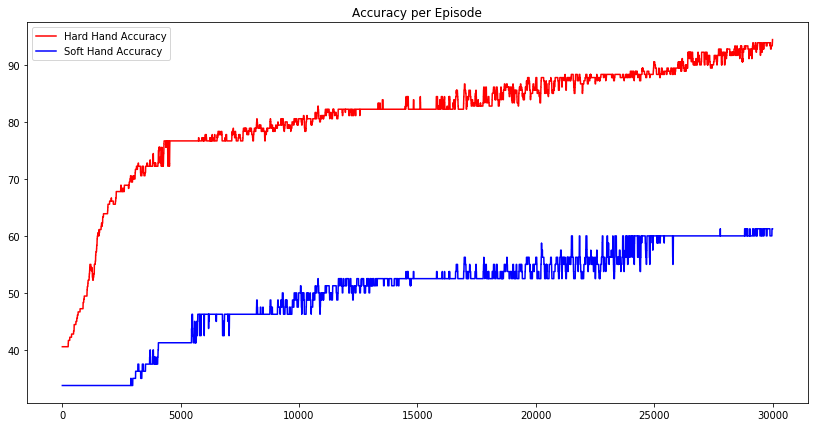

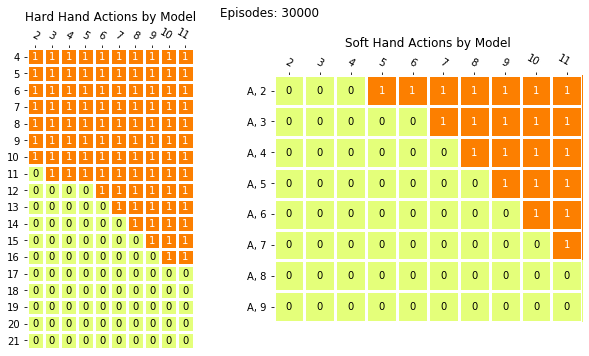

Hard Acc Final: 94.44, Soft Acc Final: 61.25


In [51]:
# Plot the results
plot_results(loggers)
hard_final, soft_final = evaluate(model, display_result=True, episode_idx=TOTAL_EPISODES)
print(f'Hard Acc Final: {hard_final:0.2f}, Soft Acc Final: {soft_final:0.2f}')